## Load Airport and Flow Data

In [67]:
%load_ext autoreload
%autoreload 2

from scipy.signal import savgol_filter
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()
flow_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_flight_flow_df_rev1.pickle"
flight_flow_data = pd.read_pickle(flow_matrix_path)

infection_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_infection_rate_df_rev1.pickle"
infection_matrix_df = pd.read_pickle(infection_matrix_path)

apt_df_path = "../recovery_rate/recovery_rate_training_dataframes/data/airport_state_weather_prediction_added_rev1.pickle"
airport_df = pd.read_pickle(apt_df_path)

hourly_arrival_mats = pd.read_pickle("../recovery_rate/recovery_rate_training_dataframes/data/hourly_arrival_matrix_updated_rev1.pickle")
hourly_dep_mats = pd.read_pickle("../recovery_rate/recovery_rate_training_dataframes/data/hourly_departure_matrix_updated_rev1.pickle")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load DL Model and Dataset

In [68]:
from dataset import RecoveryRateDataset
from torch.utils.data import DataLoader
from model_lightning import LSTMEstimator
import torch

SEQUENCE_LENGTH = 3
features_to_drop = ['reg_type', 'reg_bool_type', 'reg_cause', "weather_prediction"]

rr_dataset = RecoveryRateDataset(apt_df_path, features_to_drop=features_to_drop, sequence_length=SEQUENCE_LENGTH,
                                 fill_with='backfill')

rr_dataloader = DataLoader(rr_dataset, batch_size=133, shuffle=False, num_workers=8)

model = LSTMEstimator(len(rr_dataset.feature_names), initial_dense_layer_size=512, dense_parameter_multiplier=1,
                          dense_layer_count=8, lstm_layer_count=2, lstm_hidden_units=512, dropout=0.5,
                          sequence_length=SEQUENCE_LENGTH, loss="huber")

checkpoint = torch.load("artifacts/model-35cgln33-v24/model.ckpt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["state_dict"])
model.eval()

LSTMEstimator(
  (feature_extracting_layers): Sequential(
    (linear0): Linear(in_features=16, out_features=512, bias=True)
    (relu0): LeakyReLU(negative_slope=0.01)
    (dropout0): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.5, inplace=False)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (dropout2): Dropout(p=0.5, inplace=False)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
    (relu3): LeakyReLU(negative_slope=0.01)
    (dropout3): Dropout(p=0.5, inplace=False)
    (linear4): Linear(in_features=512, out_features=512, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
    (dropout4): Dropout(p=0.5, inplace=False)
    (linear5): Linear(in_features=512, out_features=512, bias=True)
    (relu5): LeakyReLU(negative_slope=0.01)
    (dropout5): Dropout(p=0.5, inplace=Fa

In [9]:
from tqdm import tqdm
rr_prediction_list = []

for x, y in tqdm(rr_dataloader):
    rr_prediction_list.append(model(x).detach().numpy())

rr_prediction_list = [np.squeeze(array, axis=1) for array in rr_prediction_list]
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list.insert(0, rr_prediction_list[0])
rr_prediction_list = [np.diag(array) for array in rr_prediction_list]

100%|██████████| 4341/4341 [03:17<00:00, 21.99it/s]


## Create RR, IR and FR Columns

In [84]:
mult_index = pd.MultiIndex.from_product([np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01")), range(0, 96, 4)], names=["date", "tw"])
new_df = pd.DataFrame(index=mult_index)

ff_list = []
inf_list = []
rr_list = []
p_state_list = []
median_rr_list = [np.diag(airport_df["recovery_rate"].groupby("apt", sort=False).median().reindex(airport_df.index.unique("apt")).values)] * len(range(0, len(flight_flow_data), 133))
hourly_arr_list = []
hourly_dep_list = []

for i in range(0, len(flight_flow_data), 133):
    rr_list.append(np.diag(airport_df.loc[:, "recovery_rate"].fillna(method="backfill").fillna(airport_df.loc[:, "recovery_rate"].median()).iloc[i:i+133].values))
    p_state_list.append(airport_df.loc[:, "norm_delay_per_f"].iloc[i:i+133].values.clip(min=0, max=1))
    ff_list.append(flight_flow_data.iloc[i:i+133, :].values)
    inf_list.append(infection_matrix_df.iloc[i:i+133, :].values)
    hourly_arr_list.append(hourly_arrival_mats.iloc[i:i+133, :].values)
    hourly_dep_list.append(hourly_dep_mats.iloc[i:i+133, :].values)

new_df["rr_vector"] = rr_list
new_df["p_vector"] = p_state_list
new_df["infmat"] = inf_list
new_df["flowmat"] = ff_list
new_df["median_rr"] = median_rr_list
new_df["rr_prediction"] = rr_prediction_list
new_df["hourly_arr"] = hourly_arr_list
new_df["hourly_dep"] = hourly_dep_list

## Delta P plots


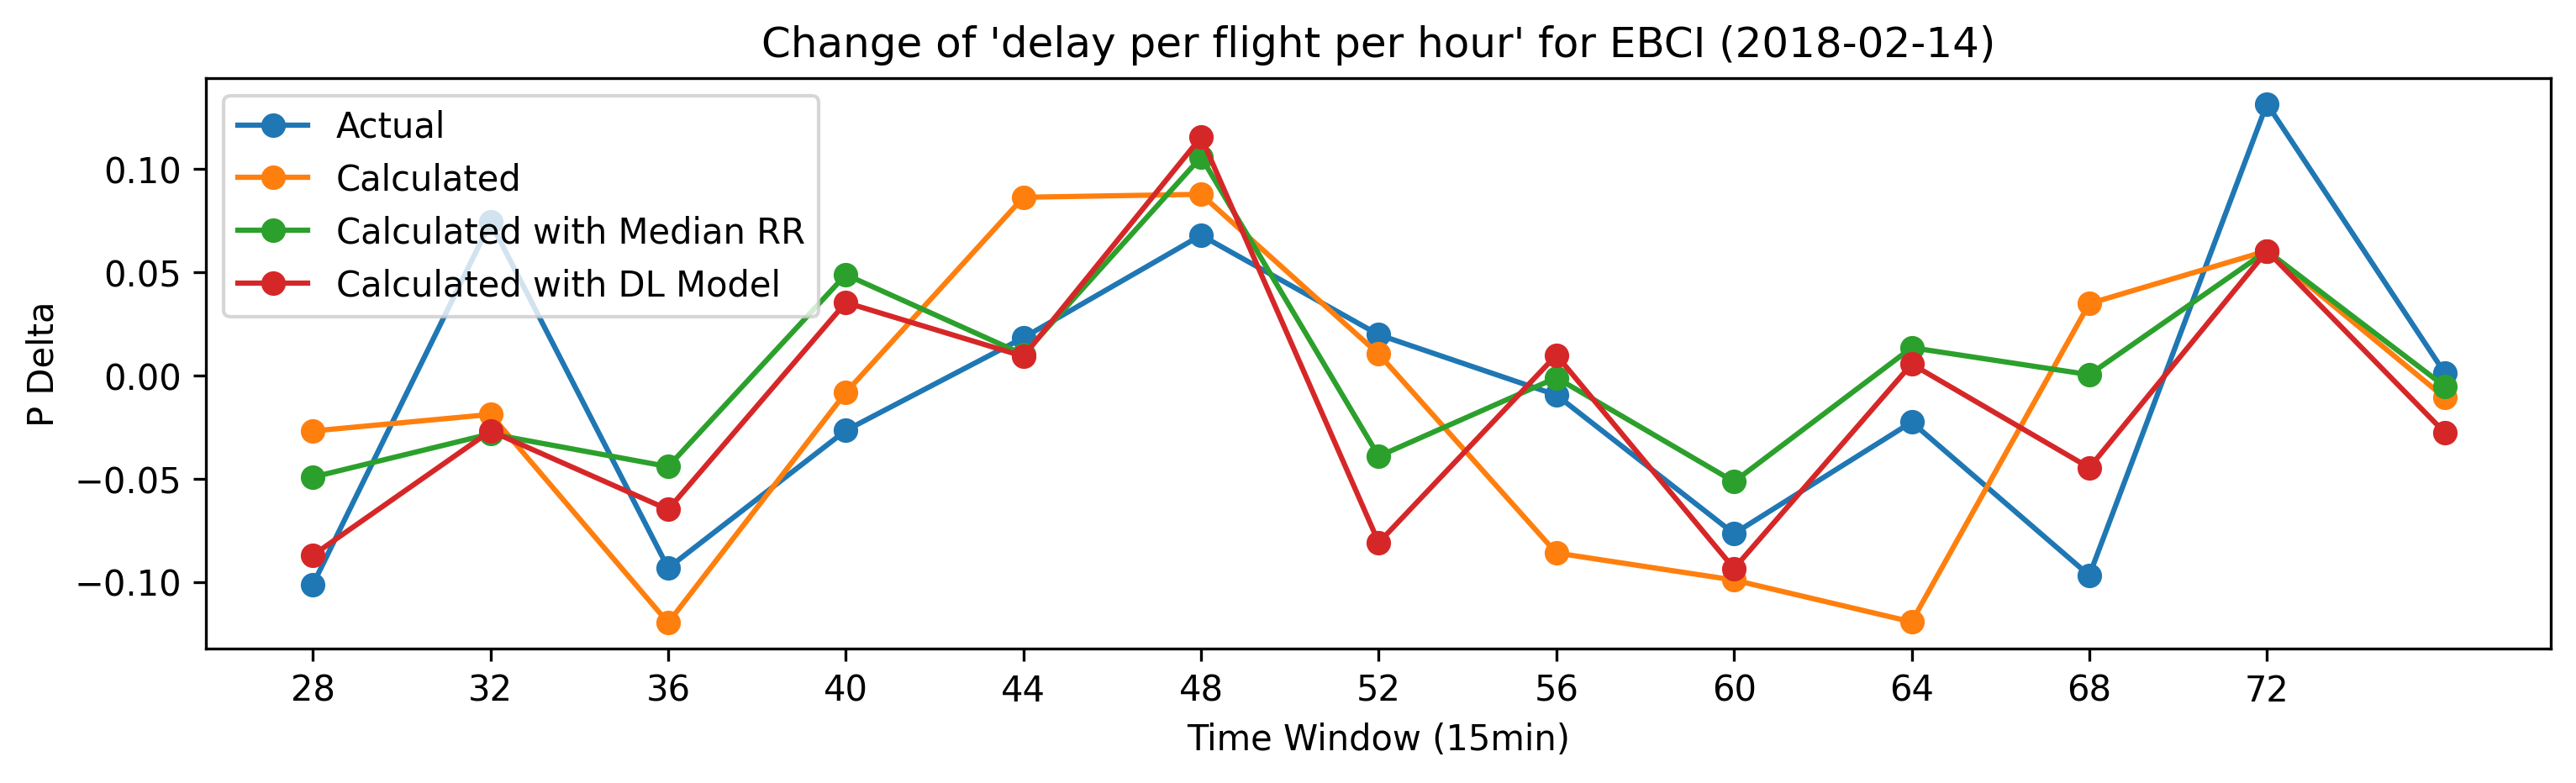

In [182]:
random = True
tw_tuple =(24, 76, 4)
tw=slice(tw_tuple[0], tw_tuple[1], 1)
if random:
    date = str(rng.choice(np.arange(np.datetime64("2018-01-01"), np.datetime64("2018-07-01"))))
    apt_idx = rng.integers(0, 133)
else:
    date="2018-04-05"
    apt_idx = 5
    
index = (date, tw)

apt_name = airport_df.index.unique("apt").tolist()[apt_idx]

def diff_prop(slice_df, inf_label = "infmat", rr_label="rr_vector", p_label="p_vector"):
    return (((slice_df[inf_label] - slice_df[rr_label]) @ slice_df[p_label]) - ((slice_df[inf_label] @ slice_df[p_label]) * slice_df[p_label])) / 1

slice_df = deepcopy(new_df.loc[index, :])

def apt_index(vector):
    return vector[apt_idx]

plot_kwargs = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", legend=True, xticks=range(tw_tuple[0]+4, tw_tuple[1], 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})",
                   marker="o")

slice_df["calc_p"] = slice_df.apply(diff_prop, axis=1).values
slice_df["calc_p_median_rr"] = slice_df.apply(diff_prop, axis=1, rr_label="median_rr").values
slice_df["calc_p_rr_prediction"] = slice_df.apply(diff_prop, axis=1, rr_label="rr_prediction").values

slice_df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual")
slice_df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated")
slice_df["calc_p_median_rr"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated with Median RR")
slice_df["calc_p_rr_prediction"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated with DL Model")

plt.show()

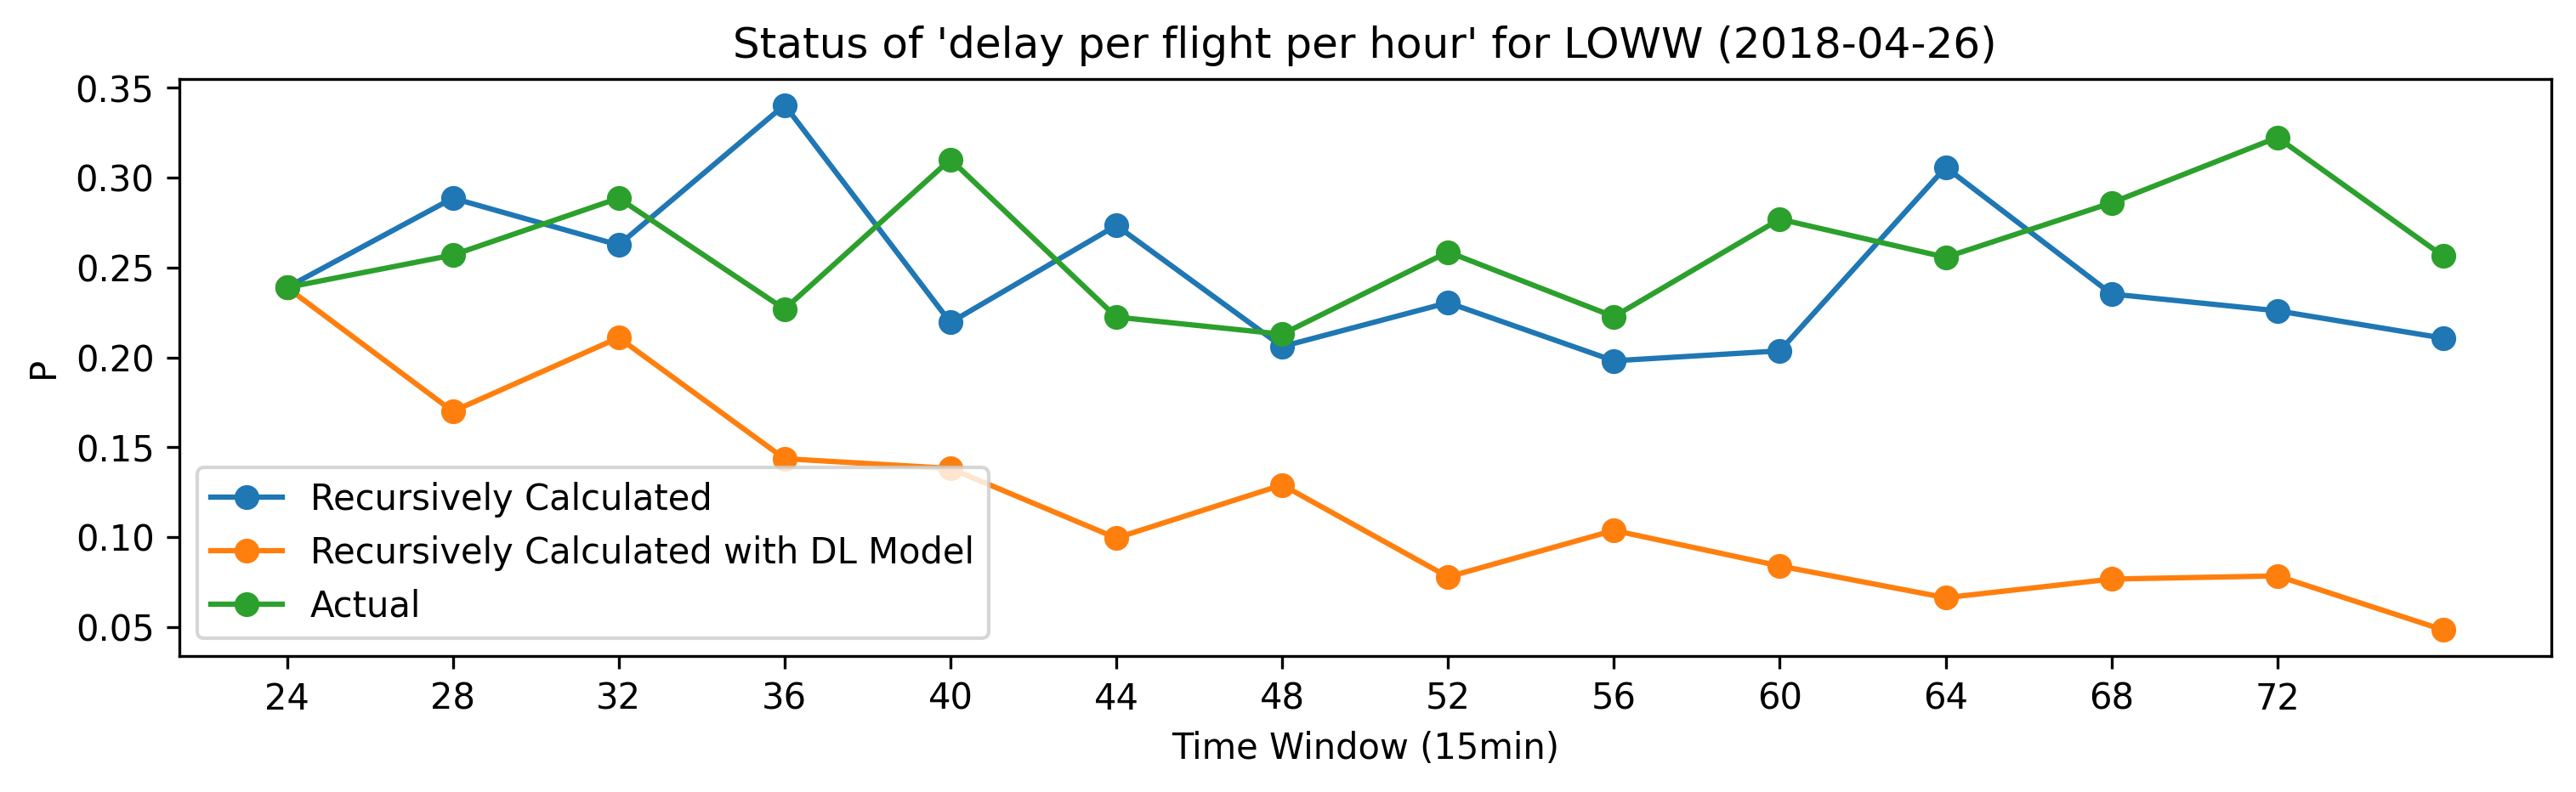

In [86]:
plot_kwargs_cumulative = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P", legend=True, xticks=range(tw_tuple[0], tw_tuple[1], 4), title=f"Status of 'delay per flight per hour' for {apt_name} ({date})",
                   marker="o")

slice_df["p_vector_cumulative"] = slice_df["p_vector"].values
slice_df["p_vector_cumulative_pred"] = slice_df["p_vector"].values

for idx in range(len(slice_df) - 1):
    slice_df["p_dots_cumulative"] = slice_df.apply(diff_prop, axis=1, p_label="p_vector_cumulative").values
    slice_df["p_vector_cumulative"][idx+1] = slice_df["p_vector_cumulative"][idx] + slice_df["p_dots_cumulative"][idx]
    slice_df["p_vector_cumulative"][idx+1] = np.clip(slice_df["p_vector_cumulative"][idx+1], 0, 1)
    
    slice_df["p_dots_cumulative_pred"] = slice_df.apply(diff_prop, axis=1, rr_label="rr_prediction", p_label="p_vector_cumulative_pred").values
    slice_df["p_vector_cumulative_pred"][idx+1] = slice_df["p_vector_cumulative_pred"][idx] + slice_df["p_dots_cumulative_pred"][idx]
    slice_df["p_vector_cumulative_pred"][idx+1] = np.clip(slice_df["p_vector_cumulative_pred"][idx+1], 0, 1)
    
    
slice_df["p_vector_cumulative"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Recursively Calculated")
slice_df["p_vector_cumulative_pred"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Recursively Calculated with DL Model")
slice_df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).plot(**plot_kwargs_cumulative, label="Actual")
plt.show()

## Delta P Plots with Uncertainties

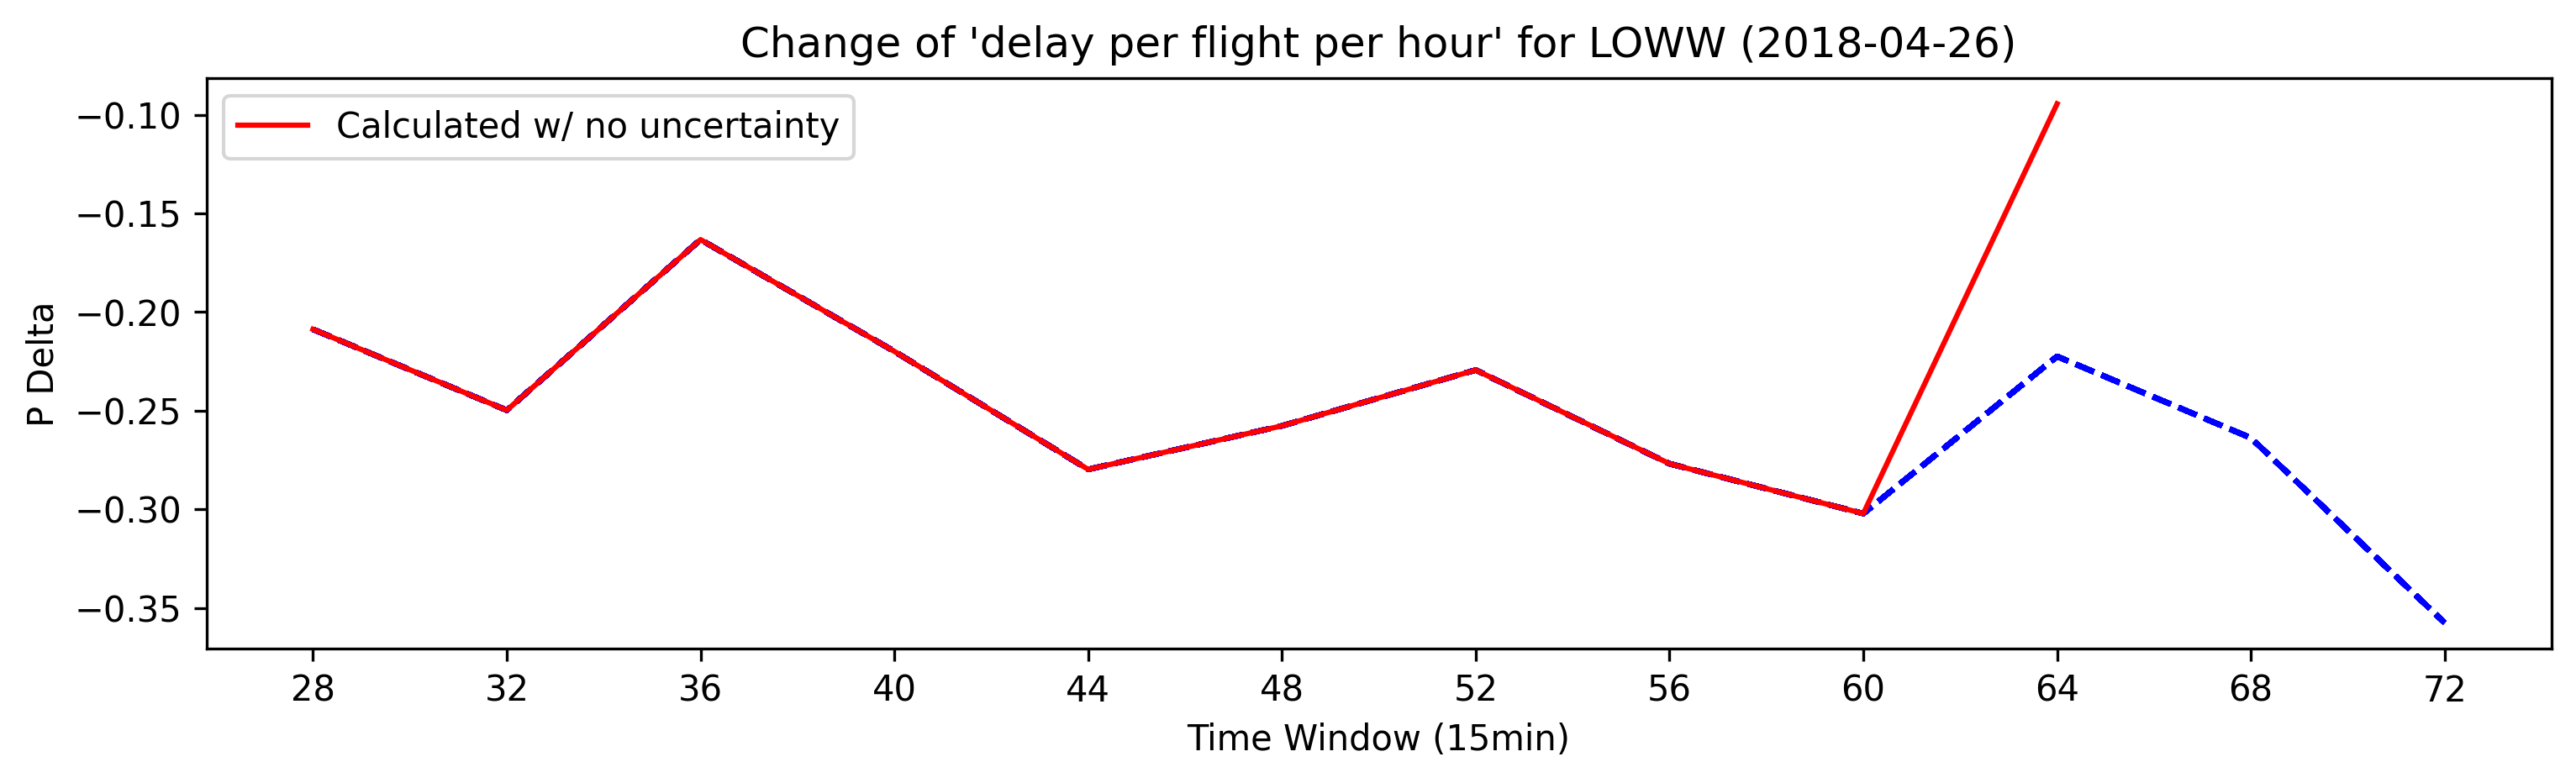

In [87]:
from uncertainty_matrix_to_discrete import UncertaintyMatrix, divide_flowmats_to_interval, convert_flowmat_to_infmat

arrival_times = rng.integers(5, 60*12, size=(133, 133))
uncertainty_matrix = UncertaintyMatrix(new_df.loc[index, "flowmat"].iloc[0], mean_values=arrival_times, std_values=rng.uniform(10, 120, size=(133, 133)))

sample_flowmats = [uncertainty_matrix.draw_sample() for i in range(100)]
sample_flowmats_divided = [divide_flowmats_to_interval(sample_flowmat, interval=60) for sample_flowmat in sample_flowmats]
sample_infmats = convert_flowmat_to_infmat(sample_flowmats_divided)

flowmat_no_uncertainty = [UncertaintyMatrix(new_df.loc[index, "flowmat"].iloc[0], mean_values=arrival_times, 
                                                 std_values=np.zeros((133, 133))).draw_sample()]
flowmat_no_uncertainty_divided = [divide_flowmats_to_interval(sample_flowmat, interval=60) for sample_flowmat in flowmat_no_uncertainty]
infmat_no_uncertainty = convert_flowmat_to_infmat(flowmat_no_uncertainty_divided)


plot_kwargs_for_uncertainty = dict(figsize=(12, 3), xlabel="Time Window (15min)", ylabel="P Delta", xticks=range(tw_tuple[0]+4, tw_tuple[1], 4), title=f"Change of 'delay per flight per hour' for {apt_name} ({date})")

calculation_history = []
calculation_history_for_all_apt = []
for infmat_sequence in sample_infmats:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence[0:len(df)]
    df["calc_with_new_infmat"] = df.apply(diff_prop, inf_label="new_infmat", axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty, alpha=0.8, color="b", linestyle="--", label="Calculated with Uncertainty")
    calculation_history.append(df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).values)
    calculation_history_for_all_apt.append(df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).shift(1).values)
    
for infmat_sequence in infmat_no_uncertainty:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence[0:len(df)]
    df["calc_with_new_infmat"] = df.apply(diff_prop, inf_label="new_infmat", axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty, legend=True, ax=plt.gca(), color="r", label="Calculated w/ no uncertainty")
    calculation_history.append(df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).values)
#df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
#df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")
plt.show()

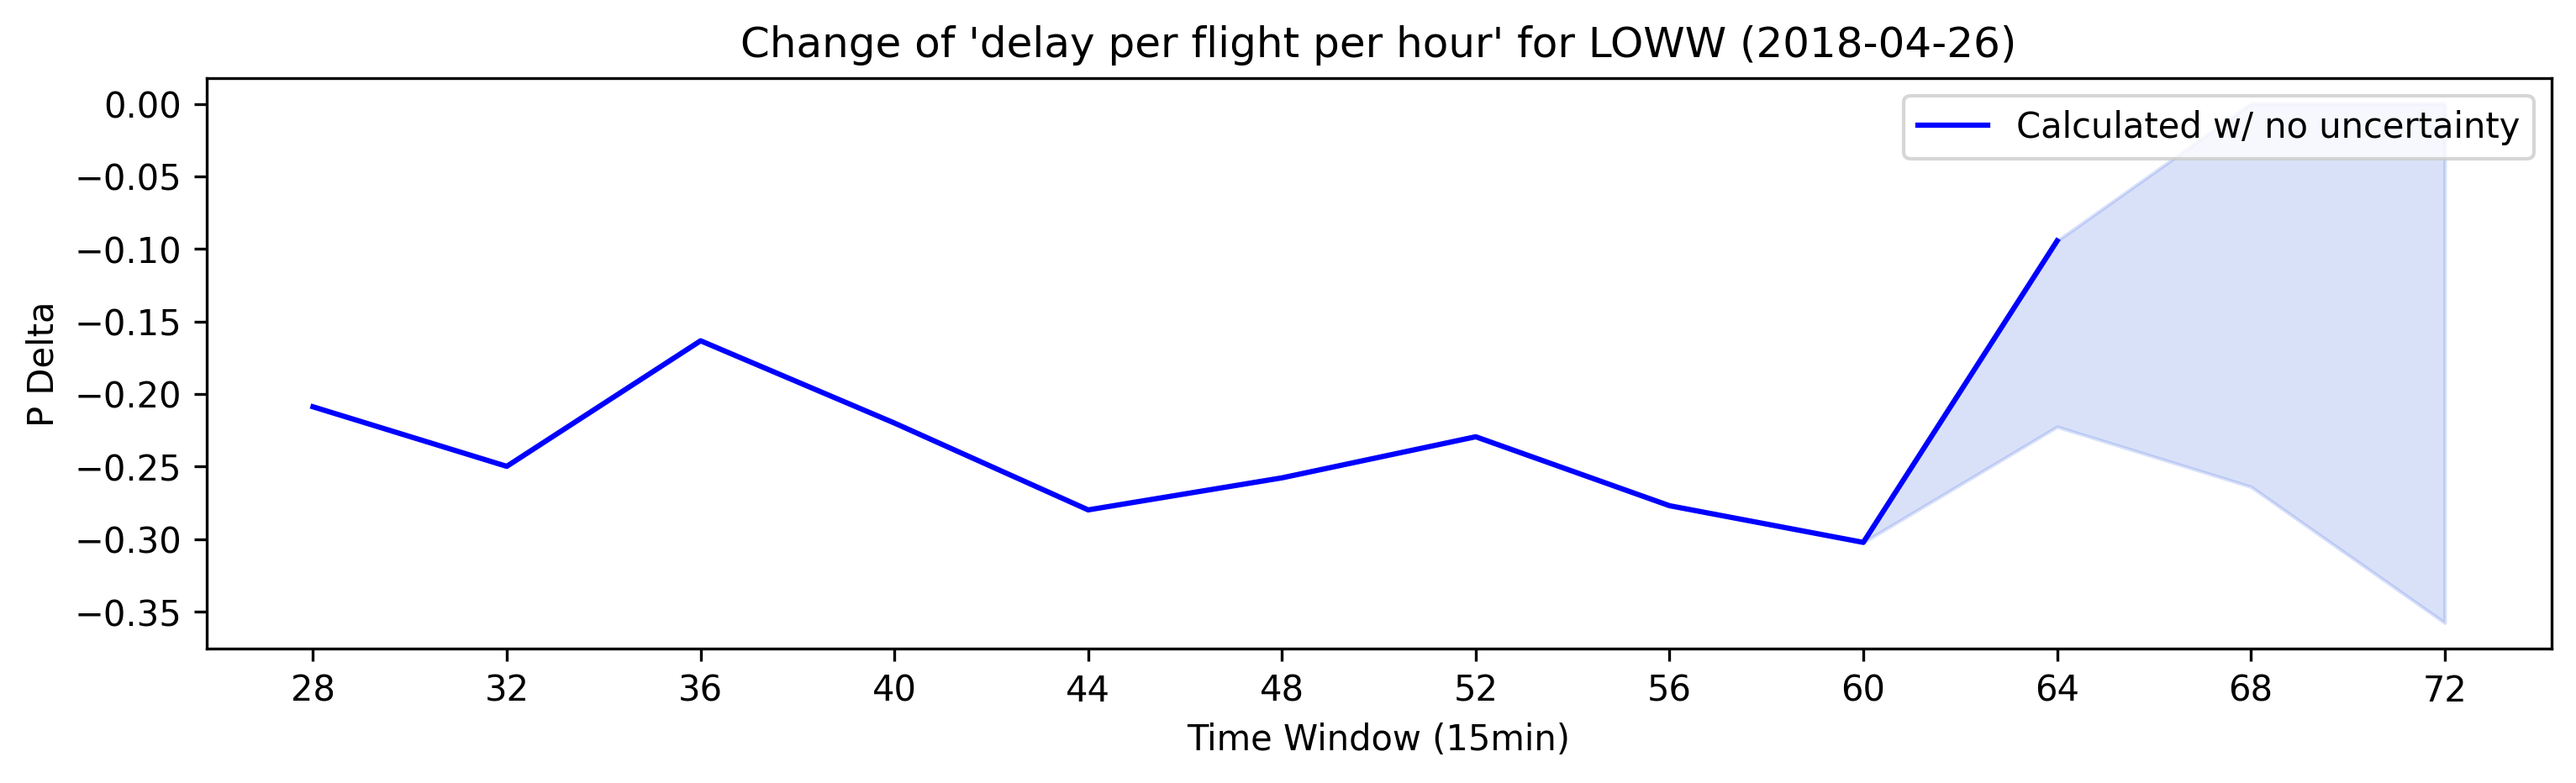

In [89]:
def pad_arrays(expected_len, array_list):
    padded_calc_history = []
    expected_array_len = 10

    for array in calculation_history:
        
        len_deficit = expected_array_len - array.shape[0]
        while len_deficit < 0:
            expected_array_len = array.shape[0]
            len_deficit = expected_array_len - array.shape[0]
            
        if len_deficit != 0:
            padded_calc_history.append(np.pad(array, (0, len_deficit), constant_values=0))
        else:
            padded_calc_history.append(array)
            
    return padded_calc_history

# df["calc_p"].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs, label="Calculated", color="b")
# df["p_vector"].reset_index(level="date", drop=True).apply(apt_index).diff().plot(**plot_kwargs, label="Actual", color="orange")

for infmat_sequence in infmat_no_uncertainty:
    df = deepcopy(slice_df.iloc[0:len(infmat_sequence), :])
    df["new_infmat"] = infmat_sequence[0:len(df)]
    df["calc_with_new_infmat"] = df.apply(diff_prop, inf_label="new_infmat", axis=1).values
    df["calc_with_new_infmat"].iloc[0:-1].reset_index(level="date", drop=True).apply(apt_index).shift(1).plot(**plot_kwargs_for_uncertainty, legend=True, ax=plt.gca(), color="b", label="Calculated w/ no uncertainty")

padded_calc_history = pad_arrays(12, calculation_history)
max_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).max(axis=0)
min_p_delta_values = np.nan_to_num(np.vstack(padded_calc_history)).min(axis=0)
plt.gca().fill_between(x=range(tw_tuple[0]+4, tw_tuple[1], 4), y1=max_p_delta_values[1:], y2=min_p_delta_values[1:], color="royalblue", alpha=0.2)
plt.show()

In [90]:
import plotly.graph_objects as go

tw_idx = 0
bar_df = pd.DataFrame(data={"calc_p": slice_df["calc_p"][tw_idx].astype("float"), "rr": np.diagonal(slice_df["rr_vector"][tw_idx]),
                            "calc_p_plus1": slice_df["calc_p"][tw_idx+1].astype("float"), "calc_p_plus2": slice_df["calc_p"][tw_idx+2].astype("float")}, index=airport_df.index.unique("apt"))
plot_kwargs_bar = dict(figsize=(10, 4), kind="bar", title=f"P Delta values at time window: {list(range(tw_tuple[0], tw_tuple[1]))[tw_idx:tw_idx+3]} ({date})")

bar_df["positive"] = bar_df["calc_p"] > 0
# bar_df["calc_p"].plot(**plot_kwargs_bar, color=bar_df["positive"].map({True: 'r', False: 'limegreen'}))
# plt.xticks(rotation=90)
# plt.gca().tick_params(axis='x', which='major', labelsize=4)
# plt.show()

import plotly.express as px

#fig = px.bar(bar_df.reset_index(), x="apt", y=["calc_p", "calc_p_plus1", "calc_p_plus2"], color="calc_p", labels={"calc_p": "P Delta", "rr": "Recovery Rate", "apt": "Airport"}, 
            
             #color_continuous_scale=px.colors.diverging.RdYlGn_r, range_color=[-1, 1], barmode="group")
fig = go.Figure(data=[
    go.Bar(name='1st Hr', x=airport_df.index.unique("apt"), y=bar_df["calc_p"]),
    go.Bar(name='2nd Hr', x=airport_df.index.unique("apt"), y=bar_df["calc_p_plus1"]),
    go.Bar(name='3rd Hr', x=airport_df.index.unique("apt"), y=bar_df["calc_p_plus2"]), 
])

fig.update_layout(showlegend=False, barmode='group')
fig.update_xaxes(categoryorder='array', categoryarray= list(airport_df.index.unique("apt")))
fig.show()

## Load RL Agent

In [132]:
from stable_baselines3 import PPO
from rl_files.custom_gym_env import AirTrafficFlow

def find_operable_index(action_idx, n_apt=n_apt):
    diagonal = np.diag_indices(n_apt, ndim=2)
    #If entry_index corresponds to a diagonal index, skip to next one.
    diagonal_entries = [n_apt*row + column for row, column in zip(diagonal[0], diagonal[1])]
    all_entries = range(n_apt*n_apt)
    operable_entries = [entry for entry in all_entries if entry not in diagonal_entries]
    operation_idx = operable_entries[action_idx]
    row, column = divmod(operation_idx, n_apt)
    return (row, column)

n_apt = 40
env = AirTrafficFlow(n_apt=n_apt)
agent = PPO.load("rl_files/agents/model_best.zip")

In [212]:
def reduce_2_napt(value, n_apt):
    if value.ndim == 2:
        return value[0:n_apt, 0:n_apt]
    else:
        return value[0:n_apt]
    
def convert2inf(array):
    np.fill_diagonal(array, 0)
    return np.divide(array, array.sum(axis=1, keepdims=True), out=np.zeros_like(array.astype(float)), where=(array > 0), casting="unsafe")

reduced_df = slice_df.applymap(reduce_2_napt, n_apt=n_apt)

obs_list = []
for idx in range(3):
    arrival = reduced_df["hourly_arr"].iloc[idx]
    obs_list.append(arrival)
    
for idx in range(3):
    dep = reduced_df["hourly_dep"].iloc[idx]
    obs_list.append(dep)
    
    
reduced_df["hourly_inf"] = reduced_df["hourly_arr"] + reduced_df["hourly_dep"]
reduced_df["hourly_inf"] = reduced_df["hourly_inf"].apply(convert2inf)
reduced_df["calc_p_hourly"] = reduced_df.apply(diff_prop, inf_label="hourly_inf", axis=1).values

## P Deltas with Hourly Infection Matrices and Reduced Apt Counts

In [184]:
import plotly.graph_objects as go

tw_idx = 0

col_name = "calc_p_hourly"
r_bar_df = pd.DataFrame(data={"calc_p": reduced_df[col_name][tw_idx].astype("float"), "rr": np.diagonal(reduced_df["rr_vector"][tw_idx]),
                            "calc_p_plus1": reduced_df[col_name][tw_idx+1].astype("float"), "calc_p_plus2": reduced_df[col_name][tw_idx+2].astype("float")}, index=airport_df.index.unique("apt")[0:n_apt])

plot_kwargs_bar = dict(figsize=(10, 4), kind="bar", title=f"P Delta values at time window: {list(range(tw_tuple[0], tw_tuple[1]))[tw_idx:tw_idx+3]} ({date})")

r_bar_df["positive"] = r_bar_df["calc_p"] > 0
# bar_df["calc_p"].plot(**plot_kwargs_bar, color=bar_df["positive"].map({True: 'r', False: 'limegreen'}))
# plt.xticks(rotation=90)
# plt.gca().tick_params(axis='x', which='major', labelsize=4)
# plt.show()

import plotly.express as px

#fig = px.bar(bar_df.reset_index(), x="apt", y=["calc_p", "calc_p_plus1", "calc_p_plus2"], color="calc_p", labels={"calc_p": "P Delta", "rr": "Recovery Rate", "apt": "Airport"}, 
            
             #color_continuous_scale=px.colors.diverging.RdYlGn_r, range_color=[-1, 1], barmode="group")
             

fig = go.Figure(data=[
    go.Bar(name='1st Hr', x=airport_df.index.unique("apt")[0:n_apt], y=r_bar_df["calc_p"]),
    go.Bar(name='2nd Hr', x=airport_df.index.unique("apt")[0:n_apt], y=r_bar_df["calc_p_plus1"]),
    go.Bar(name='3rd Hr', x=airport_df.index.unique("apt")[0:n_apt], y=r_bar_df["calc_p_plus2"]), 
])

fig.update_layout(showlegend=False, barmode='group')
fig.update_xaxes(categoryorder='array', categoryarray= list(airport_df.index.unique("apt"))[0:n_apt])
fig.show()

True

In [221]:
np.set_printoptions(suppress=False)
obs = env.reset(hourly_mat_list=obs_list, recovery_rates=np.diagonal(slice_df["rr_vector"][tw_idx]))

done = False
while not done:
    action, _ = agent.predict(obs)
    obs, rewards, done, metric = env.step(action)
    h = np.array_equal(env.hourly_matrix_list[3], obs_list[3])
    print(h)
    if h == False:
        break
    
    if rewards != 0:
        print(metric)
        print(action)
        print(rewards)
        h = np.array_equal(env.hourly_matrix_list[3], obs_list[3])
        print(h)
        break

(4, 34)
True
(38, 21)
True
(38, 21)
True
(19, 13)
True
(17, 2)
True
(21, 16)
True
(6, 19)
True
(38, 21)
True
(6, 19)
True
(38, 21)
True
(6, 19)
True
(38, 21)
True
(38, 21)
True
(15, 4)
True
(31, 30)
True
(38, 21)
True
(6, 19)
True
(38, 21)
True
(38, 21)
True
(38, 21)
True
(15, 4)
True
(34, 18)
True
(19, 6)
True
(31, 30)
True
(38, 21)
True
(38, 21)
True
(38, 21)
True
(38, 21)
True
(21, 22)
True
(38, 21)
True
(38, 21)
True
(30, 29)
True
(4, 26)
True
(38, 21)
True
(3, 15)
True
(22, 2)
True
(38, 21)
True
(2, 34)
True
(2, 30)
True
(31, 30)
True
(34, 18)
True
(13, 37)
True
(38, 21)
True
(30, 6)
True
(34, 18)
True
(38, 21)
True
(6, 19)
True
(15, 4)
True
(15, 4)
True
(17, 2)
True
(38, 21)
True
(38, 21)
True
(2, 30)
True
(38, 21)
True
(38, 21)
True
(9, 21)
True
(6, 19)
True
(38, 21)
True
(15, 4)
True
(38, 21)
True
(38, 21)
True
(38, 21)
True
(38, 21)
True
(31, 30)
True
(9, 21)
True
(15, 4)
True
(38, 21)
True
(38, 21)
True
(15, 4)
True
(6, 19)
True
(15, 4)
True
(15, 4)
True
(6, 19)
True
(15, 4)


In [204]:
obs_list[3][36, 26]

0

In [194]:
obs_list[3][9, 21]

0

In [175]:
obs_list[3][38, 21]

#reduced_df["modified_inf"] = reduced_df["hourly_arr"] + reduced_df["hourly_dep"]
#slice_df["calc_p_hourly_modified"] = slice_df.apply(diff_prop, inf_label="modified_inf", axis=1).values


0